# MIDDEN Chlor-alkali Model - Open Exploration

## Model initialization

In [1]:
from __future__ import (division, print_function, absolute_import, unicode_literals)
from ema_workbench import (RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, 
                           ema_logging, perform_experiments, save_results, load_results)
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework import (salib_samplers, samplers, util,
                                        MultiprocessingEvaluator, SequentialEvaluator) 
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

import numpy.lib.recfunctions as rf
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import pandas as pd

C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\site-packages\xarray\core\formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

model = ExcelModel("excelmodel", wd="./Models", model_file='MIDDEN Decarbonization options chlor-alkali final.xlsx')

#name of the sheet
model.sheet = "Experiment"

# Specification of the uncertainties
model.uncertainties = [IntegerParameter("Price_scenario", 1, 3),               # Integer value 1, 2, 3
                       RealParameter("Discount_rate", 0.0075, 0.075),           # May fluctuate between 2% and 5%
                       RealParameter("Production_uncertainty", 0.95, 1.05),    # May fluctuate between between 85% and 115% 
                       RealParameter("Efficiency_gain", 0.0015, 0.0075),       # Yearly efficiency gain approx 0.5% (DNGVL)
                       IntegerParameter("Investment_year", 2020, 2025) 
                      ]


# Specification of the policies
model.levers = [IntegerParameter('Electric_boiler_investments', 0, 2), 
                IntegerParameter('Biomass_boiler_investments', 0, 1),
                IntegerParameter('Zero_gap_investments', 0, 2),
                IntegerParameter('Peak_shaving_investments', 0, 1), # 0=None; 1=Electric boilers; 2=MVR technology; 3=Hybrid
                IntegerParameter('Energy_tax', 0, 2),               # 0=None; 1=10%; 2=20%
                IntegerParameter('Coal_plants_shutdown', 0, 1)      # 0=Present policy, 1=Envisaged policy
                #IntegerParameter("Investment_year", 2020, 2025)         # Integer value range 2020 – 2030
               ]

# Specification of the outcomes
model.outcomes = [ScalarOutcome("Direct_emissions_2030", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Direct_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_emissions_2030", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Total_emissions_2030", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Total_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("IRR", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("NPV", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Investment_cost", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Yearly_production", kind=ScalarOutcome.MAXIMIZE)
                 ]

 ### Running experiment with policies


In [3]:
#Running with policies
n_scenarios = 500
n_policies = 216 #*5
results_bckp = './Data/Results chlor-alkali - {} scenarios {} policies.tar.gz'.format(n_scenarios, n_policies)

counter = util.Counter()
policies = samplers.sample_levers(model, n_policies)

try:
    # Load results if experiment has already been conducted
    results = load_results(results_bckp)

except IOError:
    # Running in parallel   
    with MultiprocessingEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, policies)
    
    #Running in series
    #results = perform_experiments(model, n_scenarios)
    
    save_results(results, results_bckp)

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\Edzard\Documents\MIDDEN modeling\Data\Results chlor-alkali - 500 scenarios 216 policies.tar.gz


In [4]:
# Creating experiment DataFrame
experiment_data=pd.DataFrame(experiments)
outcome_data = pd.DataFrame(outcomes)
results_df=pd.concat([experiment_data, outcome_data], axis=1)

In [5]:
import seaborn as sns

## Feature scoring

In [6]:
import seaborn as sns
import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

experiments, outcomes = results

C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Feature scoring uncertainties to performance metrics

In [7]:
# Defining the x space for feature scoring
x = experiments
x = rf.drop_fields(x, ['Electric_boiler_investments', 'Biomass_boiler_investments', 
                       'Zero_gap_investments', 'Peak_shaving_investments', 
                       'Energy_tax','Coal_plants_shutdown', 'Investment_year',
                       'policy','model'], 
                   asrecarray=True)

In [8]:
# Defining the y-space for the feature scoring
y_df = pd.DataFrame(outcomes)
y_df=y_df[['Direct_emission_change','Indirect_emission_change','Total_emission_change','NPV','IRR', 'Investment_cost']]

y_dict = y_df.to_dict('list')
for key in y_dict.keys():
    y_dict[key] = np.array(y_dict[key])
y = y_dict

In [9]:
fs_all = get_feature_scores_all(x, y)
fs_all

C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

,Direct_emission_change,Indirect_emission_change,Total_emission_change,NPV,IRR,Investment_cost
Discount_rate,0.228101,0.023141,0.019882,0.170150,0.313322,0.307717
Efficiency_gain,0.346937,0.140913,0.159058,0.032244,0.329138,0.313646
Price_scenario,0.093667,0.015191,0.013323,0.720642,0.058665,0.070679
Production_uncertainty,0.331295,0.820754,0.807737,0.076964,0.298875,0.307958


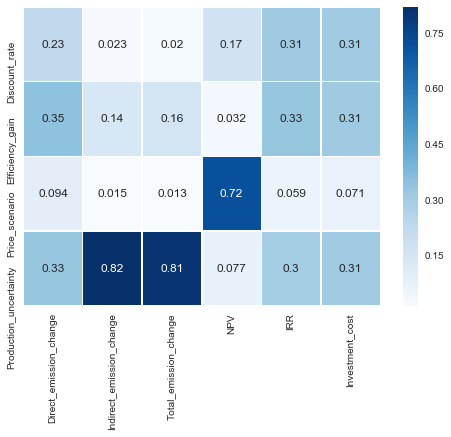

In [10]:
sns.heatmap(fs_all, annot=True, cmap='Blues', linewidths=0.5)
plt.show()

### Feature scoring for policy levers

In [11]:
# Defining the x space for feature scoring
x = experiments
x = rf.drop_fields(x, ['Discount_rate','Efficiency_gain','Price_scenario','Production_uncertainty',
                       'policy', 'model'], 
                   asrecarray=True)
fs_all = get_feature_scores_all(x, y)

C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

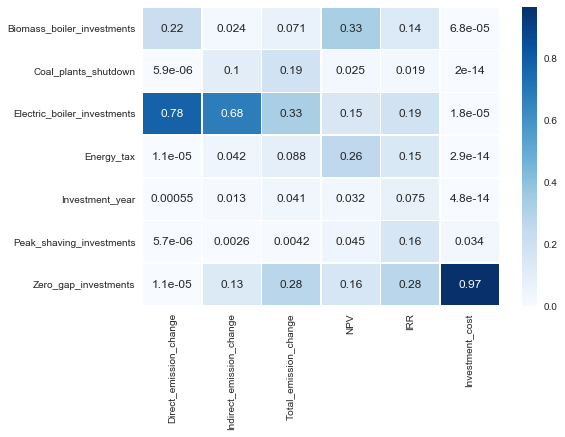

In [12]:
sns.heatmap(fs_all, annot=True, cmap='Blues', linewidths=0.5)
plt.show()

## Filtering output space to explore desired outcomes

In [13]:
import copy
data = copy.copy(outcomes)
data = pd.DataFrame(data)

In [14]:
# Filtering scenarios
data['NPV_pos']=data.NPV>0 
data['Direct_emissions_ETS'] = data.Direct_emissions_2030<167
data['Total_emission_change_neg'] = data.Total_emission_change<0
results_df['Filter']= data['NPV_pos']&data['Direct_emissions_ETS']&data['Total_emission_change_neg']

In [15]:
filtered_results=results_df.loc[results_df['Filter']]

In [16]:
print(len(filtered_results), len(results_df), len(filtered_results)/len(results_df))

34640 108000 0.3207407407407407


In [17]:
filtered_results.tail()

,Discount_rate,Efficiency_gain,Investment_year,Price_scenario,Production_uncertainty,Biomass_boiler_investments,Coal_plants_shutdown,Electric_boiler_investments,Energy_tax,Peak_shaving_investments,...,Direct_emission_change,Indirect_emissions_2030,Indirect_emission_change,Total_emissions_2030,Total_emission_change,IRR,NPV,Investment_cost,Yearly_production,Filter
107990,0.037272,0.004503,2025,2,1.032351,0,0,1,2,0,...,-51.036497,996.601663,2.853910,1137.966364,-48.182587,0.035833,1.988785e+07,9.033010e+07,874.401210,True
107991,0.012532,0.003792,2022,2,1.006722,0,0,1,2,0,...,-50.786680,966.166559,-2.910249,1103.004494,-53.696929,0.032775,1.887961e+07,9.033010e+07,852.693183,True
107992,0.051839,0.005513,2023,2,1.020312,0,0,1,2,0,...,-51.800904,977.338374,-4.820710,1115.694966,-56.621614,0.006550,3.433789e+06,9.033010e+07,864.204310,True
107996,0.050250,0.001695,2023,2,0.994947,0,0,1,2,0,...,-50.316263,954.148377,-3.594342,1089.262317,-53.910605,0.003719,1.943938e+06,9.033010e+07,842.720289,True
107997,0.009787,0.006867,2023,2,1.002502,0,0,1,2,0,...,-54.521424,939.905781,-25.109031,1072.222522,-79.630454,0.035858,2.076955e+07,9.033010e+07,849.119021,True


C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

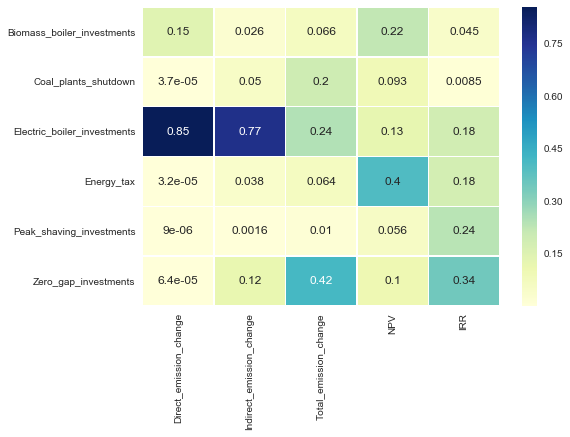

In [18]:
# Selecting relevant frames from filters 

# Policies
x_df = filtered_results[['Electric_boiler_investments', 'Biomass_boiler_investments', 
                         'Zero_gap_investments', 'Peak_shaving_investments', 
                         'Energy_tax','Coal_plants_shutdown' ]]
x = x_df.to_records(index=False)


# Outcomes
y_df = filtered_results[['Direct_emission_change','Indirect_emission_change','Total_emission_change','NPV','IRR']]
y_dict = y_df.to_dict('list')
for key in y_dict.keys():
    y_dict[key] = np.array(y_dict[key])

y = y_dict

fs_all = get_feature_scores_all(x, y)
sns.heatmap(fs_all, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.show()

## Dimensional stack of filtered space 

#### Dimensional stack of uncertainty space

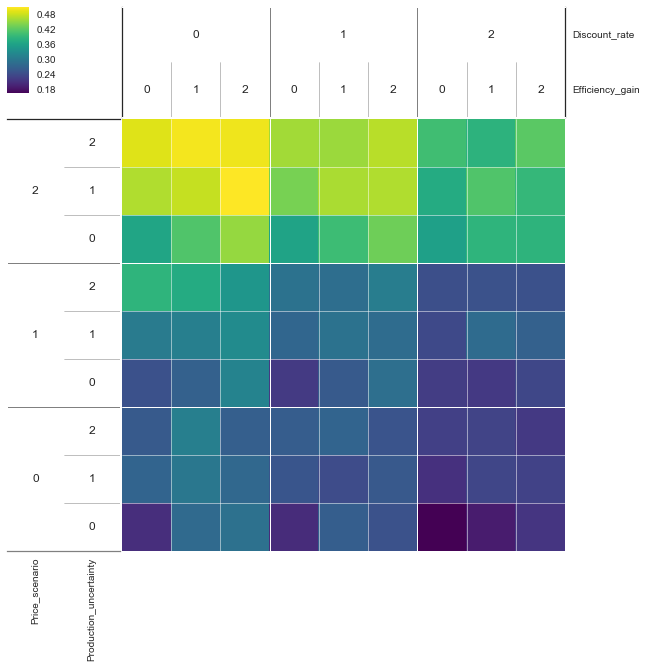

In [19]:
from ema_workbench.analysis import dimensional_stacking

# Selecting successful policies
x_df = results_df[['Discount_rate','Efficiency_gain', 
                         'Price_scenario','Production_uncertainty' ]]
x = x_df.to_records(index=False)

# Filtering output space
y = np.array(results_df['Filter'])

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=3)
plt.show()

#### Dimensional stack of policy space

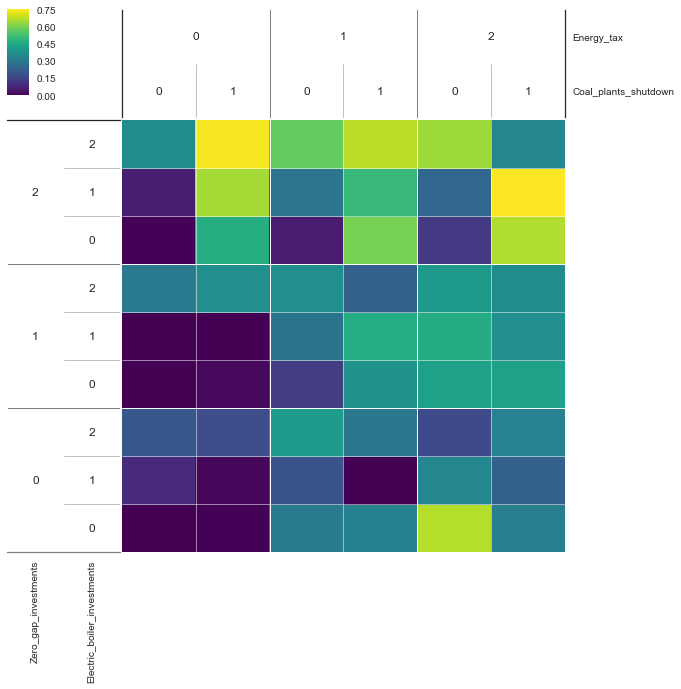

In [20]:
from ema_workbench.analysis import dimensional_stacking

# Selecting successful policies
x_df = results_df[['Electric_boiler_investments','Coal_plants_shutdown', 
                         'Energy_tax','Zero_gap_investments' ]]
x = x_df.to_records(index=False)

# Filtering output space
y = np.array(results_df['Filter'])

dimensional_stacking.create_pivot_plot(x,y, 5, nbins=4)
plt.show()

## Visualizing filtered output space

#### Filtered output space as a subset

In [21]:
import plotly.plotly as py
import plotly.graph_objs as go

parallel_plot_data = [
    go.Parcoords(
        line = dict(color = 'rgb(0, 176, 240)'
                   ),
        
        dimensions = list([
            dict(range = [0,250],
                 constraintrange = [0,167],
                 label = 'Direct emissions 2030 (kton CO2)', 
                 values = list(results_df['Direct_emissions_2030'])),
            dict(range = [-400,400],
                 label = 'Indirect emission change (kton CO2)', 
                 values = list(results_df['Indirect_emission_change'])),
            dict(range = [-250,250],
                 constraintrange = [-250,-105.13],
                 label = 'Total emissions change (kton CO2)', 
                 values = list(results_df['Total_emission_change'])),
            dict(range = [-1,3],
                 constraintrange = [0,3],
                 label = 'Internal rate of return (%)', 
                 values = list(results_df['IRR'])),
            dict(range = [0,1.1*10**8],
                 constraintrange = [10**6,1.1*(10**8)],
                 label = 'Investment cost (€)', 
                 values = list(results_df['Investment_cost'])),
        ])
    )
]

py.iplot(parallel_plot_data, filename = 'parcoord-dimensions')

#### Filtered output space in combination with no policy scenarios

In [22]:
# Filtering no policy output space
results_df['no policy']=results_df['policy']=="{'Biomass_boiler_investments': 0, 'Coal_plants_shutdown': 0, 'Electric_boiler_investments': 0, 'Energy_tax': 0, 'Peak_shaving_investments': 0, 'Zero_gap_investments': 0}"

In [23]:
# function for assigning colors to output space subsets
def f(row):
    if row['no policy']:
        val=1                # Black 'rgb(0, 0, 0)'
    elif row['Filter']:
        val=2                # Blue 'rgb(0, 176, 240)'
    else:
        val=0                # Grey 'rgb(109, 109, 109)'
    return val


In [24]:
# Sorting for plotly
results_df=results_df.sort_values(['no policy','Filter'], ascending=[False,False])

In [25]:
results_df['color'] = results_df.apply(f, axis=1)

In [26]:
import plotly.plotly as py
import plotly.graph_objs as go

parallel_plot_data = [
    go.Parcoords(
        line = dict(color = results_df['color'],
                    colorscale=[[0, 'rgb(109, 109, 109)'], [1, 'rgb(0, 0, 0)'],[2, 'rgb(0, 176, 240)']]
                   ),
        
        dimensions = list([
            dict(range = [0,250],
                 #constraintrange = [0,167],
                 label = 'Direct emissions 2030 (kton CO2)', 
                 values = list(results_df['Direct_emissions_2030'])),
            dict(range = [-400,400],
                 label = 'Indirect emission change (kton CO2)', 
                 values = list(results_df['Indirect_emission_change'])),
            dict(range = [-250,250],
                 #constraintrange = [-250,-105.13],
                 label = 'Total emissions change (kton CO2)', 
                 values = list(results_df['Total_emission_change'])),
            dict(range = [-1,3],
                 #constraintrange = [0,3],
                 label = 'Internal rate of return (%)', 
                 values = list(results_df['IRR'])),
            dict(range = [0,1.1*10**8],
                 #constraintrange = [10**6,1.1*(10**8)],
                 label = 'Investment cost (€)', 
                 values = list(results_df['Investment_cost'])),
        ])
    )
]

py.iplot(parallel_plot_data, filename = 'parcoord-dimensions')